In [1]:
import sqlglot
from sqlglot import exp

def extract_dependencies(sql: str, dialect="duckdb") -> set[str]:
    tree = sqlglot.parse_one(sql, dialect=dialect)

    deps = set()
    for table in tree.find_all(exp.Table):
        if table.db:
            deps.add(f"{table.db}.{table.name}")
        else:
            deps.add(table.name)

    return deps


In [41]:
import duckdb
import pathlib
def get_duckdb_connection():
    path = "/home/davsean/duckdb.db"
    pathlib.Path(path).unlink(missing_ok=True)
    conn = duckdb.connect("/home/davsean/duckdb.db")
    return conn

db = get_duckdb_connection()

In [7]:
db.execute("show all tables;").df()

,database,schema,name,column_names,column_types,temporary


In [8]:
from pathlib import Path

schemas = sorted(
    p.name
    for p in Path("../sqlmesh/models").iterdir()
    if p.is_dir()
)

for schema in schemas:
    db.execute(f"CREATE SCHEMA IF NOT EXISTS {schema};")


In [11]:
sql_base = open('../master.sql', 'r').read()
#db.sql("create schema raw;")
db.sql("use raw;")
db.sql(sql_base)
db.commit()
db.close()

In [2]:
from dataclasses import dataclass

@dataclass
class View:
    schema: str
    filename: str
    select_sql: str
    dependencies: list[str]
    
    @property
    def view_name(self):
        return f"{self.schema}.{self.filename.replace('.sql', '')}"
    
class ViewSet:
    def __init__(self, views: dict[str, View]):
        self.views = views
    
    def add_view(self, view: View):
        self.views[view.view_name] = view

def gather_views(base_directory: str) -> ViewSet:
    views = {}
    for schema in sorted(
        p.name
        for p in Path(base_directory).iterdir()
        if p.is_dir()
    ):
        views[schema] = {}
        for view in sorted(
            p.name
            for p in Path(f"{base_directory}/{schema}").iterdir()
            if p.is_file()
        ):
            with open(f"{base_directory}/{schema}/{view}", "r") as f:
                views[schema][view] = f.read()
            
    view_list = ViewSet({})
    for schema, view_dict in views.items():
        for view_name, view_sql in view_dict.items():
            deps = extract_dependencies(view_sql)
            view_list.add_view(View(schema, view_name, view_sql, list(deps)))
    return view_list

def render_view(schema: str, name: str, select_sql: str):
    return f"""
    CREATE OR REPLACE VIEW {schema}.{name} AS
    {select_sql}
    """
    

In [34]:
sql = """
create or replace view stg_sra_accessions as
SELECT
    Accession AS accession,
    Submission AS submission,
    Status AS status,
    CAST(Updated AS DATE) AS updated_date,
    Updated AS updated_timestamp,
    Published AS published,
    Received AS received,
    Type AS type,
    Center AS center,
    Visibility AS visibility,
    Alias AS alias,
    Experiment AS experiment,
    Sample AS sample,
    Study AS study,
    Loaded AS loaded,
    Spots AS spots,
    Bases AS bases,
    Md5sum AS md5sum,
    BioSample AS biosample,
    BioProject AS bioproject,
    ReplacedBy AS replaced_by
FROM
    raw.src_sra_accessions
WHERE
    CAST(Updated AS DATE) BETWEEN @start_ds AND @end_ds
"""
dependencies = extract_dependencies(sql)
print(dependencies)

{'raw.src_sra_accessions', 'stg_sra_accessions'}


In [38]:
gather_views('../sqlmesh/models_new')

['raw.src_geo_samples', 'supp_file', 'raw.src_geo_series', 'raw.src_geo_platforms', 'has_geo_computed_rnaseq', 'raw.src_geo_gse_with_rna_seq_counts', 'geometadb.gsm', 'geometadb.geo_supplemental_files', 'geometadb.gse_gsm', 'geometadb.gpl', 'geometadb.gse_gpl', 'geometadb.gse']


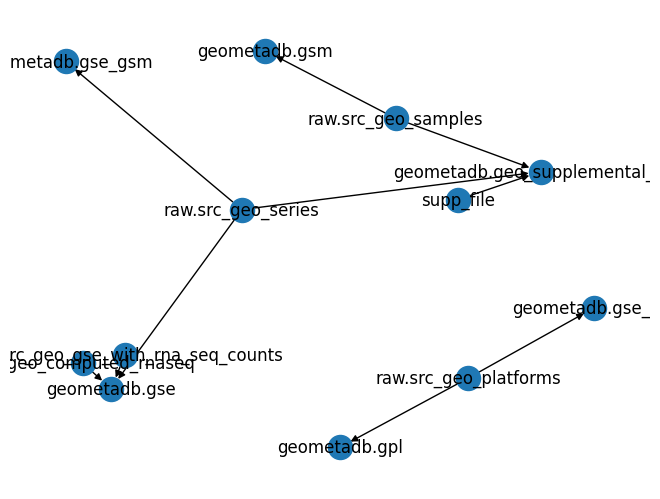

In [4]:
import networkx as nx
from pathlib import Path

graph = nx.DiGraph()

for view in gather_views('../sqlmesh/models_new').views.values():
    graph.add_node(view.view_name)

    for dep in view.dependencies:
        graph.add_edge(dep, view.view_name)

nx.draw(graph, with_labels=True)
order = list(nx.topological_sort(graph))
print(order)

In [11]:
import shutil, os, duckdb
shutil.rmtree('/home/davsean/duckdb.db', ignore_errors=True)
try:
    os.unlink("/home/davsean/duckdb.db")
except FileNotFoundError:
    pass

sql = """
 CREATE or replace SECRET minio (
    TYPE s3,
    KEY_ID '',
    SECRET '',
    ENDPOINT 'minio.cancerdatasci.org',
    URL_STYLE 'path',
    REGION 'us-east-1',
    USE_SSL True
);

create if not exists schema raw;
use raw;

-- SRA ----------------------------------------------

create or replace view src_sra_accessions as select * from read_parquet('s3://omicidx/sra/raw/accessions/*parquet');

create or replace view src_sra_studies as select * from read_parquet('s3://omicidx/sra/raw/study/**/*parquet');
create or replace view src_sra_samples as select * from read_parquet('s3://omicidx/sra/raw/sample/**/*parquet');   
create or replace view src_sra_runs as select * from read_parquet('s3://omicidx/sra/raw/run/**/*parquet');    
create or replace view src_sra_experiments as select * from read_parquet('s3://omicidx/sra/raw/experiment/**/*parquet');

-- GEO ----------------------------------------------

create or replace view src_geo_series as select * from read_ndjson_auto('s3://omicidx/geo/raw/gse/**/*ndjson.gz');
create or replace view src_geo_samples as select * from read_ndjson_auto('s3://omicidx/geo/raw/gsm/**/*ndjson.gz');
create or replace view src_geo_platforms as select * from read_ndjson_auto('s3://omicidx/geo/raw/gpl/**/*ndjson.gz');
create or replace view src_geo_gse_with_rna_seq_counts as select * from read_ndjson_auto('s3://omicidx/geo/raw/gse_with_rna_seq_counts.jsonl.gz');


-- PUBLICATIONS -------------------------------------

-- create or replace view src_pubmed_metadata as select * from read_parquet('s3://omicidx/pubmed/raw/*parquet');
-- create or replace view src_icite_metadata as select * from read_parquet('s3://omicidx/icite/raw/icite_metadata/*parquet');
-- create or replace view src_icite_citations as select * from read_parquet('s3://omicidx/icite/raw/icite_opencitations/*parquet');
-- create or replace view src_europepmc_references as select * from read_parquet('s3://omicidx/europepmc/raw/*parquet');

-- BIOSAMPLE ----------------------------------------

create or replace view src_bioprojects as select * from read_parquet('s3://omicidx/biosample/raw/bioproject/raw/*parquet');
create or replace view src_biosamples as select * from read_parquet('s3://omicidx/biosample/raw/biosample/raw/*parquet');

create if not exists schema geometadb;
"""

with duckdb.connect("/home/davsean/omicidx.duckdb") as db:

    sql_base = open('../master.sql', 'r').read()
    db.sql(sql_base)

    all_views = gather_views('../sqlmesh/models_new')

    for name in order:
        if name not in all_views.views:
            continue
        if all_views.views[name].schema == "raw":
            continue
        schema, table = name.split(".")
        view_sql = all_views.views[name].select_sql
        db.sql(render_view(schema, table, view_sql))

In [54]:
db.commit()
db.close()